<a href="https://colab.research.google.com/github/liamkarl/PHYS-408-Term-Project/blob/main/FDTD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

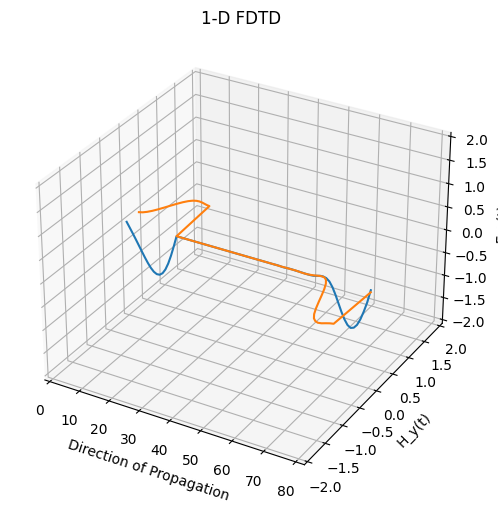

In [1]:
# One-Dimensional Finite-Difference Time-Domain Method
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import matplotlib.animation as animation
from IPython.display import HTML

# grid properties:
nx = 81
nt = 500
dx = 0.01
c0 = 3.e8
dt = dx / (2.*c0)

# constants:
cc = c0*dt/dx

# sinusoidal wave properties:
frequency = 1 / (dt * 10)
T0 = 1.0 / frequency
tc = 5 * T0 / 2
sig = tc / 2 / np.sqrt(2 * np.log(2))

# Gaussian pulse
t0 = 20;
spread = 8;

# initialize fields:
ez = np.zeros(nx)
hy = np.zeros(nx)

# animation
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection = '3d')

def frame(t):
  ax.clear()
  plt.title("1-D FDTD")

  ax.set_xlabel('Direction of Propagation')
  ax.set_xlim3d(0, nx)
  ax.set_ylabel('H_y(t)')
  ax.set_ylim3d(-2, 2)
  ax.set_zlabel('E_z(t)')
  ax.set_zlim3d(-2, 2)

  # update magnetic field
  hy[:-1] = hy[:-1] + cc*(ez[:-1] - ez[1:])

  # correction for Hy adjacent to conducting boundary
  hy[17] = 0;
  hy[49] = 0;

  # Update electric field
  ez[1:] = ez[1:] + cc*(hy[:-1] - hy[1:])

  # correction for Ez adjacent to conducting boundary
  ez[49] = 0;
  ez[17] = 0;

  # Initiate source to start the simulation
  ez[0] = np.exp((-((t+1) * dt - 3 * np.sqrt(2) * sig)**2) / (2 * sig**2))

  # Initiate source to start the simulation
  ez[nx - 1] = np.exp(-.5*((t-t0)/spread)**2)

  x = np.arange(0, nx, 1)
  zero = np.zeros(nx)

  # plot Ez values
  plot = ax.plot(x, zero, ez)

  # plot Hy values
  plot = ax.plot(x, hy, zero)

  return plot

anim = animation.FuncAnimation(fig, frame, frames=nt, interval=16, blit=False, repeat=True)

HTML(anim.to_html5_video())

'\n# animation\nfig, ax = plt.subplots()\n\ndef animate(t):\n  ax.clear()\n  ax.set(xlim=(0, nx), ylim=(-max, max), xlabel="x", ylabel="Ez")\n  ax.plot(x, E_z_t[t][:, 50])\n\nanim = animation.FuncAnimation(fig, animate, frames=nt, interval=20, blit=False, repeat=True)\n\nHTML(anim.to_html5_video())\n'

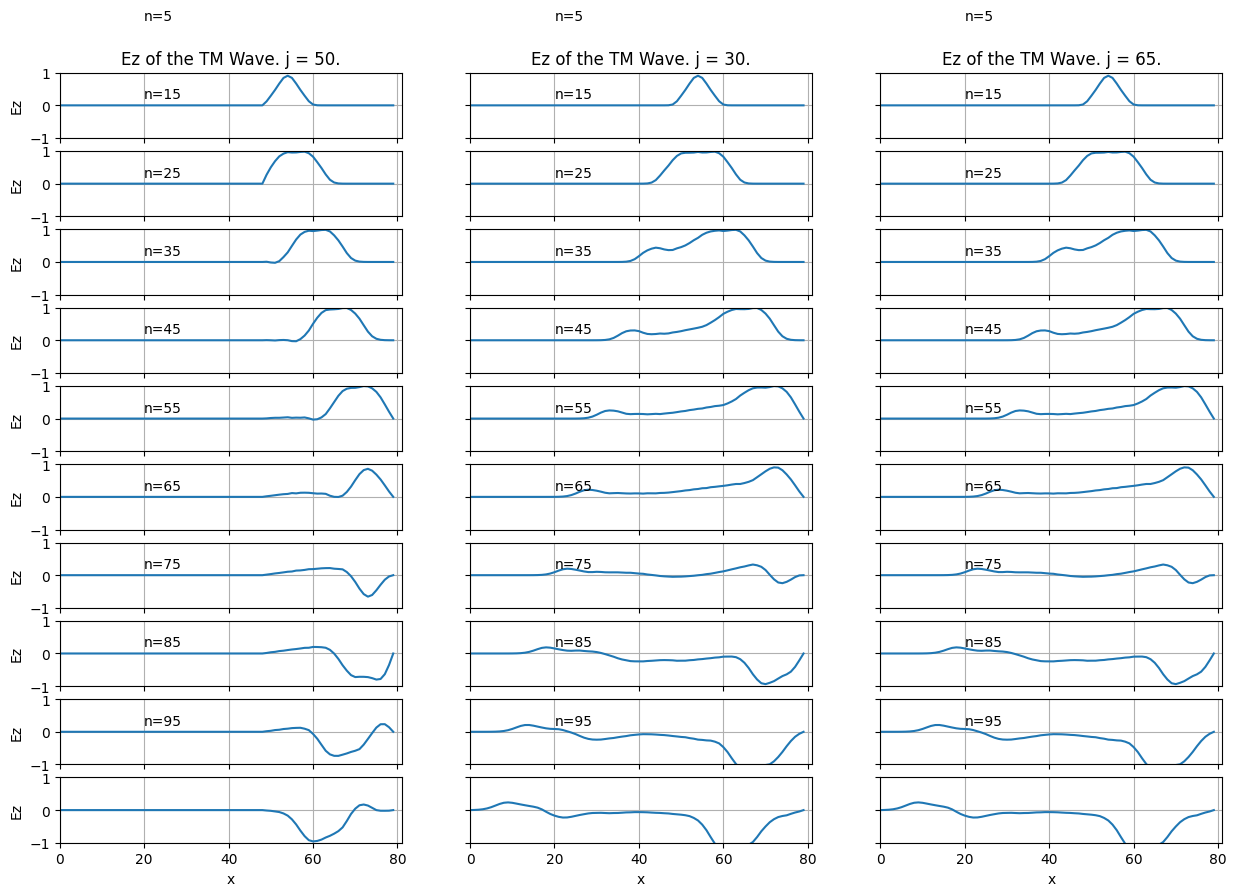

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


# FDTD 2D, TEZ polarization simulation.
# The magnetic field oscillates only in the z direction, while the electric field
# oscillates only in the x and y directions. A staggered grid in space is used to
# simulate H_z, E_x and E_y:
#     E_y(m, n+1/2) H_z(m+1/2, n+1/2)
#                   E_x(m+1/2, n)

# size of space and time period
Nx = 81
Ny = 97
nt = 99

# medium variables
u = 1.25663706212e-6
e = 8.85418781762039e-12
c = 1 / np.sqrt(u*e)
Z = np.sqrt(u / e)

# flag for testing obstructed/unobstructed
obstructed = 1

# width of incident wave, equal to 1/4 side length of conducting square
alpha = 1.

# grid size
dx = alpha/8.
dy = alpha/8.

# time steps should obey stability criterion
dT = alpha/16.

# setting up mapping variable
x = np.arange(Nx - 1)

# incident wave
source = np.zeros([Nx, Ny])

# TM Wave arrays
E_z = np.zeros([Nx - 1, Ny - 1])
H_x = np.zeros([Nx, Ny - 1])
H_y = np.zeros([Nx - 1, Ny])

E_z_t = []
H_x_t = []
H_y_t = []

# FDTD Loop
for t in range(nt):
    # TM: Update magnetic fields at time step t+1/2
    H_x[1:-1, :] = H_x[1:-1, :] - dT / dy * (E_z[1:, :] - E_z[:-1, :]) / Z
    H_y[:, 1:-1] = H_y[:, 1:-1] + dT / dx * (E_z[:, 1:] - E_z[:, :-1]) / Z

    if (obstructed):
      # Update BCs for magnetic fields on conducting square
      H_x[17:49, 33] = 0
      H_x[17:49, 65] = 0
      H_y[17, 33:65] = 0
      H_y[49, 33:65] = 0

    # Update Dirichlet BCs for magnetic fields
    H_x[0,:] = 0
    H_x[80,:] = 0
    H_y[:,0] = 0
    H_y[:,96] = 0

    # TM: Update electric field at time step t+1
    diff_H_x = Z * dT / dy * (H_x[1:, :] - H_x[:-1, :])
    diff_H_y = Z * dT / dx * (H_y[:, 1:] - H_y[:, :-1])
    E_z = E_z + (diff_H_y - diff_H_x)

    if (obstructed):
      # Update BCs for electric field on conducting square
      E_z[17:49, 33:65] = 0
      E_z[17:49, 33:65] = 0

    # Update Dirichlet BCs for electric field
    E_z[0,:] = 0
    E_z[79,:] = 0
    E_z[:,0] = 0
    E_z[:,95] = 0

    # add incident wave
    for i in range(Nx - 1):
      if (0 <= (i - 50*alpha + c*t) and (i - 50*alpha + c*t <= 8*alpha)):
        source[i, :] = np.sin(np.pi*(i - 50*alpha + c*t)/(8*alpha))

    E_z[:,:] = E_z[:,:] + source[:-1,:-1]
    H_y[:,:] = H_y[:,:] + source[:-1,:] / Z

    E_z_t.append(E_z.copy())
    if len(E_z_t) > 500:
        del E_z_t[0]

# find range and normalize
max = np.max(E_z_t[:])
E_z_t = E_z_t / max

if (obstructed):
  fig, axs = plt.subplots(10, 3, sharex='col', sharey=False)

else:
  fig, axs = plt.subplots(10, sharex='col', sharey=False)

fig.set_figheight(10)
fig.set_figwidth(15)

# Producing graphs
if (obstructed):
  for t in range (nt):
    if ((t + 5) % 10 == 0):
      t_tens = int((t - 5) / 10)

      axs[t_tens, 0].plot(x, E_z_t[t][:, 50])
      axs[t_tens, 0].axis(xmin=0, xmax=nx, ymin=-1, ymax=1)
      axs[t_tens, 0].grid(True)
      axs[t_tens, 0].text(np.round(Nx/4), max/2, "n=" + str(t))

      if t == 5:
        axs[0, 0].set_title('Ez of the TM Wave. j = 50.')

  for t in range (nt):
    if ((t + 5) % 10 == 0):
      t_tens = int((t - 5) / 10)

      axs[t_tens, 1].plot(x, E_z_t[t][:, 30])
      axs[t_tens, 1].axis(xmin=0, xmax=nx, ymin=-1, ymax=1)
      axs[t_tens, 1].grid(True)
      axs[t_tens, 1].text(np.round(Nx/4), max/2, "n=" + str(t))

      if t == 5:
        axs[0, 1].set_title('Ez of the TM Wave. j = 30.')

  for t in range (nt):
    if ((t + 5) % 10 == 0):
      t_tens = int((t - 5) / 10)

      axs[t_tens, 2].plot(x, E_z_t[t][:, 30])
      axs[t_tens, 2].axis(xmin=0, xmax=nx, ymin=-1, ymax=1)
      axs[t_tens, 2].grid(True)
      axs[t_tens, 2].text(np.round(Nx/4), max/2, "n=" + str(t))

      if t == 5:
        axs[0, 2].set_title('Ez of the TM Wave. j = 65.')

else:
  for t in range (nt):
    if ((t + 5) % 10 == 0):
      t_tens = int((t - 5) / 10)

      axs[t_tens].plot(x, E_z_t[t][:, 70])
      axs[t_tens].axis(xmin=0, xmax=nx, ymin=-1, ymax=1)
      axs[t_tens].grid(True)
      axs[t_tens].text(np.round(Nx/4), max/2, "n=" + str(t))

      if t == 5:
        axs[0].set_title('Ez of the TM Wave. Unobstructed.')

for ax in axs.flat:
    ax.set(xlabel='x', ylabel='Ez')

for ax in fig.get_axes():
    ax.label_outer()

# Stuff for animation --> not producing these results
"""
# animation
fig, ax = plt.subplots()

def animate(t):
  ax.clear()
  ax.set(xlim=(0, nx), ylim=(-max, max), xlabel="x", ylabel="Ez")
  ax.plot(x, E_z_t[t][:, 50])

anim = animation.FuncAnimation(fig, animate, frames=nt, interval=20, blit=False, repeat=True)

HTML(anim.to_html5_video())
"""